# Подготовительный этап

### Подключение библиотек

In [ ]:
%%capture

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import copy
from time import time

# вспомогательные функции
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# аугментация данных
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

Установим optuna

In [ ]:
%%capture
! pip install optuna
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

Установим CatBoostClassifier

In [ ]:
%%capture
! pip install catboost
from catboost import CatBoostClassifier

### Загрузка датасета

In [ ]:
df = pd.read_csv('hmeq.csv')

Рассмотрим данные таблицы:

In [ ]:
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


Для начала давайте рассмотрим длю пропусков в каждой колонке:

In [ ]:
df.isna().mean(axis=0)

BAD        0.000000
LOAN       0.000000
MORTDUE    0.086913
VALUE      0.018792
REASON     0.042282
JOB        0.046812
YOJ        0.086409
DEROG      0.118792
DELINQ     0.097315
CLAGE      0.051678
NINQ       0.085570
CLNO       0.037248
DEBTINC    0.212584
dtype: float64

# Работа с данными

При рассмотрении этих данных стоит учитывать тот факт, что все эти заявки - кредиты, уже одобренные прошлым алгоритмом. Из-за этого отличия в данных говорят скорее не об особенностях клиентов, а о предвзятостях существующей модели.

### Графики распределения по признакам

**Числовые признаки**

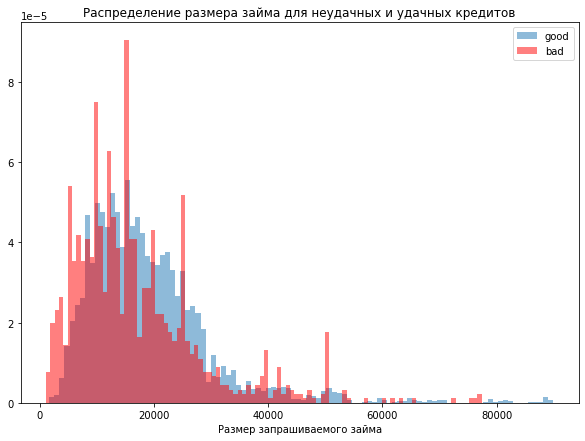

In [ ]:
plt.figure(figsize=(10, 7))
plt.hist(df['LOAN'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['LOAN'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Размер запрашиваемого займа')
plt.title('Распределение размера займа для неудачных и удачных кредитов')
plt.show()

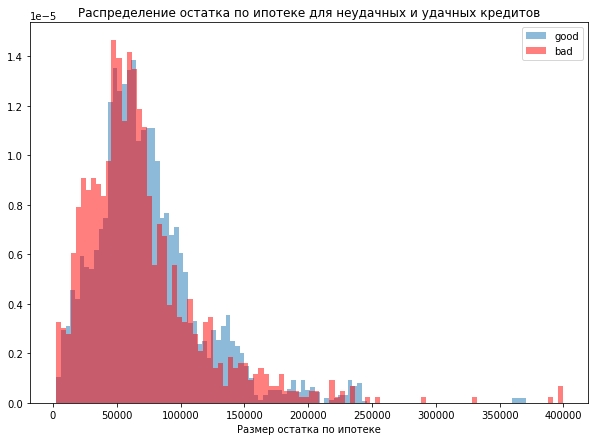

In [ ]:
plt.figure(figsize=(10, 7))

plt.hist(df['MORTDUE'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['MORTDUE'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Размер остатка по ипотеке')
plt.title('Распределение остатка по ипотеке для неудачных и удачных кредитов')

plt.show()

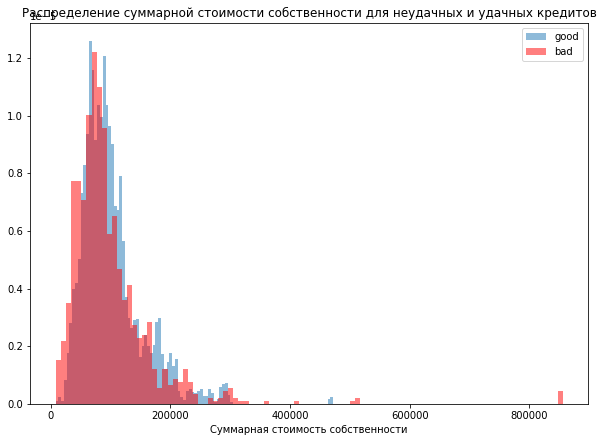

In [ ]:
plt.figure(figsize=(10, 7))

plt.hist(df['VALUE'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['VALUE'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Суммарная стоимость собственности')
plt.title('Распределение суммарной стоимости собственности для неудачных и удачных кредитов')

plt.show()

**Категориальные признаки**

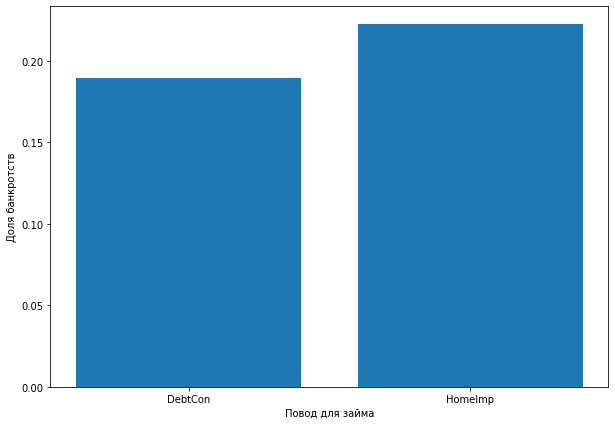

In [ ]:
plt.figure(figsize=(10, 7))
plt.bar(x=['DebtCon', 'HomeImp'], height=(df.groupby('REASON').mean()['BAD']))
plt.ylabel('Доля банкротств')
plt.xlabel('Повод для займа')
plt.show()

Интуитивно понятно, что реструктуризация долгов - потенциально более рискованная инвестиция, чем покупка для улучшения дома. Возможно прошлые данные овер-компенсировали этот риск, поэтому в нашем датасете реструктуризация статистически надежнее.

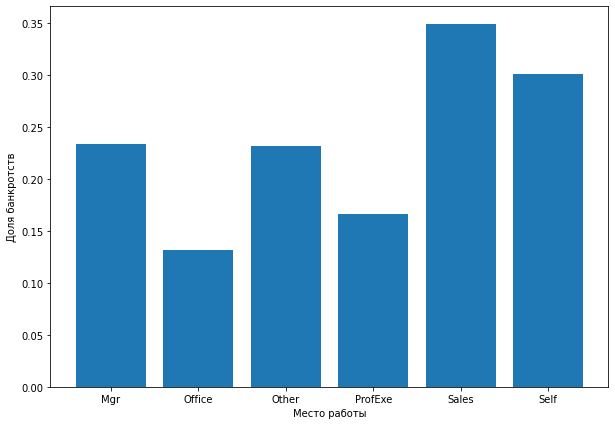

In [ ]:
plt.figure(figsize=(10, 7))
plt.bar(x=(df.groupby('JOB').mean()['BAD']).index, height=(df.groupby('JOB').mean()['BAD']))
plt.ylabel('Доля банкротств')
plt.xlabel('Место работы')

plt.show()

### Значимость признаков

Давайте оценим важность признаков с помощью t-статистики, чтобы выделить наиболее значимые для нашей классификации

In [ ]:
dfpos = df[df['BAD'] == 0].drop(['BAD', 'JOB', 'REASON'] , axis=1)
dfneg = df[df['BAD'] == 1].drop(['BAD', 'JOB', 'REASON'] , axis=1)
t = np.abs(dfpos.mean(axis=0) - dfneg.mean(axis=0)) / np.sqrt((len(dfpos) * dfpos.std(axis=0)**2 + len(dfneg) * dfneg.std(axis=0)**2)/ (len(dfpos) + len(dfneg)))


In [ ]:
t

LOAN       0.188425
MORTDUE    0.120885
VALUE      0.076650
YOJ        0.148999
DEROG      0.715846
DELINQ     0.944193
CLAGE      0.435324
NINQ       0.441615
CLNO       0.010427
DEBTINC    0.609487
dtype: float64

'DEROG', 'DELINQ' - обобщая, эти признаки говорят нам об уже просроченных кредитах. Понятно, почему эти признаки очень важны.

'DEBTINC' - отношение долга к доходу

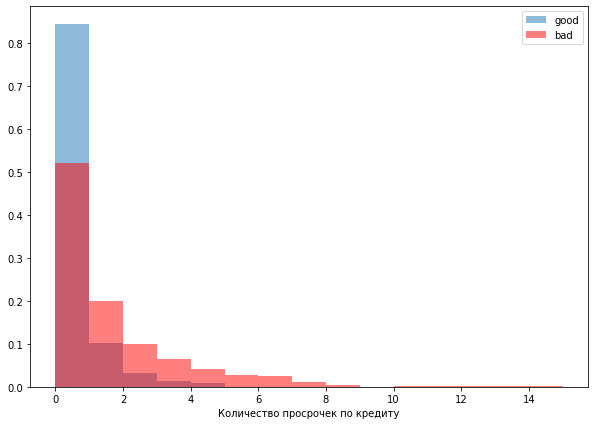

In [ ]:
plt.figure(figsize=(10, 7))

plt.hist(df['DELINQ'][df['BAD'] == 0], bins=5, alpha=0.5, label='good', density=True)
plt.hist(df['DELINQ'][df['BAD'] == 1], bins=15, alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Количество просрочек по кредиту')

plt.show()

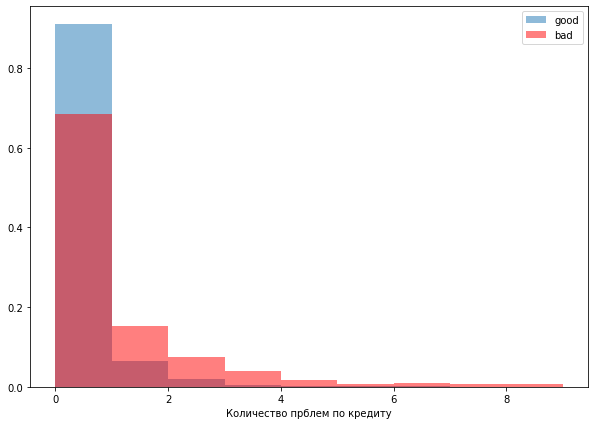

In [ ]:
plt.figure(figsize=(10, 7))

plt.hist(df['DEROG'][df['BAD'] == 0], bins=range(10), alpha=0.5, label='good', density=True)
plt.hist(df['DEROG'][df['BAD'] == 1], bins=range(10), alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Количество прблем по кредиту')

plt.show()

In [ ]:
df['REASON'].value_counts()

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64

In [ ]:
df['JOB'].value_counts()

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64

In [ ]:
df.isna().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

### Заполнение пропусков

Давайте для начала заполним пропуски в категориальных переменных отдельным значением, в числовых - средним, а переменную с наибольшим количеством пропусков пока удалим.

In [ ]:
df_pure = copy.deepcopy(df).drop('DEBTINC', axis=1)
df_pure[['JOB', 'REASON']] = df_pure[['JOB', 'REASON']].fillna('NAN')
df_pure = df_pure.fillna(df_pure.mean(axis=0))

y = df_pure['BAD'].values
X = df_pure.drop("BAD", axis=1).values

Закодируем категориальные переменные

In [ ]:
X = np.concatenate((X[:, :3], OneHotEncoder(sparse=False).fit_transform(X[:, [3, 4]]), X[:, 5:]), axis=1)

Разобьем на тренировочные и тестовые данные

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=179)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=179)

Проверим данные

In [ ]:
isnatrain, isnatest = train_test_split(df.isna().mean(axis=1), test_size=0.3, random_state=179)

# Вспомогательные функции

Рассмотрим различные критерии, по которым можно сравнить результат работы моделей

### Стандартные критерии



*   accuracy, как удобныая и интерпретируемая, но не всегда информативная метрика
*   площадь под precision-recall кривой
*   площадь по tpr/fpr кривой
*   F-мера



### Вспомогательные критерии 

Реализуем также 

*   Cohen's kappa coefficient (https://en.wikipedia.org/wiki/Cohen%27s_kappa) 

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

*   Matthews correlation coefficient (https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 



In [ ]:
def kappa(y0, y1, pos=1, neg=0):
    po = accuracy_score(y0, y1)

    pos0 = (y0 == pos).mean()
    pos1 = (y1 == pos).mean()
    pe = (pos0 * pos1) + (1 - pos0) * (1 - pos1)

    k = (po - pe) / (1 - pe)
    return k

def matthews(pred, target, pos=1, neg=0):
    tp = np.sum((pred == pos) & (target == pos))
    tn = np.sum((pred == neg) & (target == neg))
    fp = np.sum((pred == pos) & (target == neg))
    fn = np.sum((pred == neg) & (target == pos))

    if (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) == 0:
        return 0 # условность, чтобы не вылезало так много nan

    return (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

### Бизнес критерий

Было бы логично предположить, что невозврат денег для нас несет больше урона, чем бы нам принесло успешное возвращение. Это говорит нам о том, что порог выдачи кредита стоит выставить ниже чем 0.5 вероятности дефолта

Напишем функцию, которая максимизирует ожидание прибыли, исходя из предположения о том, что наша выгода составляет x% суммы, и если человек не возвращает сумму, он не возвращает ее целиком

In [ ]:
def get_prediction(mod, X_test, y_test, x=15):
    y_prob = mod.predict_proba(X_test)[:, 1]
    threshold = (x / 100) / (1 + x / 100)
    y_pred = y_prob > threshold
    return y_pred * 1.0

Введем метрику, которая оценивает лосс как упущенную выгоду, по сравнению с идеальным предсказанием.

In [ ]:
def get_gain(y_pred, y_target, loan, x=15):
    return (((y_pred == 1) & (y_target == 1)) * loan - ((y_pred == 1) & (y_target == 0)) * loan * x / 100).sum() / loan.sum()

### Объеденим в функцию

In [ ]:
logs = dict()

In [ ]:
def rate(mod, X_test, y_test, name="model", x=15):
    y_pred = mod.predict(X_test)
    print("====== " + name + " ======")
    print()
    ac = accuracy_score(y_pred, y_test)
    print(f"Accuracy:\t{accuracy_score(y_pred, y_test)}")
    print(f"Pos/neg ratio:\t{(y_pred == 1).sum() / (y_pred == 0).sum()}")
    print()

    print(f"Kappa coef:\t{kappa(y_pred, y_test)}")
    print(f"Matthews coef:\t{matthews(y_pred, y_test)}")
    print(f"ROC-AUC value:\t{roc_auc_score(y_test, mod.predict_proba(X_test)[:, 1])}")
    auc_pr = auc(*reversed((precision_recall_curve(y_test, mod.predict_proba(X_test)[:, 1]))[:2]))
    print(f"PR-AUC value:\t{auc_pr}")
    pr = precision_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    print()
    print(f"Precision:\t{pr}")
    print(f"Recall: \t{rc}")
    fscore = 2 * pr * rc / (pr + rc)
    print(f"F-score:\t{fscore}")

    loan = X_test[:, 0]
    y_pred_financial = get_prediction(mod, X_test, y_test, x=x)
    gains = get_gain(y_pred_financial, y_test, loan, x=x)
    print(f"Financial gain:\t{gains}")
    print()
    print("=======" + '=' * len(name) + "=======")
    return ac, auc_pr, fscore, gains

In [ ]:
def string_time(elapsed):
    return "%im %is" %(int(elapsed / 60), int(elapsed % 60))

In [ ]:
def run(mod, X_train, y_train, X_test, y_test, name='model', x=15):
    global logs

    start_time = time()
    mod.fit(X_train, y_train)
    end_time = time()
    ac, auc_pr, fscore, gains = rate(mod, X_test, y_test, name=name, x=x)
    elapsed = end_time - start_time
    print("Time elapsed: " + string_time(elapsed))

    logs[name] = [ac, auc_pr, fscore, gains, elapsed, name]

    return mod.predict(X_test)

### Калибровочная кривая

Для оценки результата и внесения корректировок нам также понадобится калибровочная кривая

In [ ]:
def calibration_curve(mod, X, y):
    probs = mod.predict_proba(X)[:, 1]
    vals = []
    for prob in np.arange(0, 1, 0.05):
        vals.append(y[(probs >= prob) & (probs < prob + 0.05)].mean())
    plt.plot(np.arange(0, 1, 0.05) + 0.025, vals, label='Our curve')
    plt.plot(np.arange(0, 1, 0.05) + 0.025, np.arange(0, 1, 0.05) + 0.025, label='Perfect curve')
    return vals

def build_calibration_curve(mod, X, y):
    plt.figure(figsize=(10, 10))
    vals = calibration_curve(mod, X, y)
    plt.xlabel('Predicted probability', fontdict={'size':15})
    plt.ylabel('Fraction of positive results for this probability', fontdict={'size':15})
    plt.legend()
    plt.show()

### Разное

In [ ]:
def print_vals(d):
    ans = ''
    for key, val in d.items():
        ans += key + '=' + str(val) + ', '
    return ans[:-2]

# Подготовка базовой модели

Перед сравнением моделей выведем баланс классов в исходной выборке

In [ ]:
print(f"Positive train targets: {(y_train == 1).sum()}, negative train targets: {(y_train == 0).sum()}, ratio: {(y_train == 1).sum() / (y_train == 0).sum()}")
print(f"Positive val targets: {(y_val == 1).sum()}, negative val targets: {(y_val == 0).sum()}, ratio: {(y_val == 1).sum() / (y_val == 0).sum()}")
print(f"Positive test targets: {(y_test == 1).sum()}, negative test targets: {(y_test == 0).sum()}, ratio: {(y_test == 1).sum() / (y_test == 0).sum()}")

Positive train targets: 994, negative train targets: 4072, ratio: 0.24410609037328093
Positive val targets: 96, negative val targets: 351, ratio: 0.27350427350427353
Positive test targets: 99, negative test targets: 348, ratio: 0.28448275862068967


В качестве baseline будем использовать random forest

In [ ]:
rlf_baseline = RandomForestClassifier(n_estimators=1000, random_state=179)
y_pred = run(rlf_baseline, X_train, y_train, X_test, y_test, name='Random Forest', x=15)

====== Random Forest ======

Accuracy:	0.9463087248322147
Pos/neg ratio:	0.20810810810810812

Kappa coef:	0.8308580077570711
Matthews coef:	0.8410284623553973
ROC-AUC value:	0.9902618135376756
PR-AUC value:	0.9752986314553959

Precision:	0.987012987012987
Recall: 	0.7676767676767676
F-score:	0.8636363636363635
Financial loss:	0.2009025651852634

Time elapsed: 0m 7s


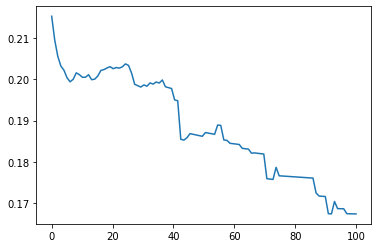

In [ ]:
x_s = np.linspace(0, 100, num=100)
y_s = [get_gain(get_prediction(rlf_baseline, X_test, y_test, x=cur), y_test, X_test[:, 0], x=cur) for cur in x_s]

plt.plot(x_s, y_s)

Заметим, что если выдавать кредит согласно предсказаниям модели, без поправки на оценку прибыли, ожидаемая прибыль будет существенно хуже:

In [ ]:
get_gain(y_pred, y_test, X_test[:, 0])

Также сравним со **случайным классификатором**

In [ ]:
random_dummy = DummyClassifier(strategy="uniform")
y_pred = run(random_dummy, X_train, y_train, X_test, y_test, name='Random Forest', x=15)

====== Random Forest ======

Accuracy:	0.47874720357941836
Pos/neg ratio:	0.9866666666666667

Kappa coef:	-0.046417699008349265
Matthews coef:	-0.05568484489855983
ROC-AUC value:	0.5
PR-AUC value:	0.610738255033557

Precision:	0.1981981981981982
Recall: 	0.4444444444444444
F-score:	0.2741433021806854
Financial loss:	0.09752982159822654

Time elapsed: 0m 0s


И **константным классификатором**

In [ ]:
constant_dummy = DummyClassifier(strategy="most_frequent")
y_pred = run(constant_dummy, X_train, y_train, X_test, y_test, name='Random Forest', x=15)

====== Random Forest ======

Accuracy:	0.7785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.5
PR-AUC value:	0.610738255033557

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial loss:	0.0

Time elapsed: 0m 0s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning:

invalid value encountered in double_scalars



# Стандартные методы классификации

###Логистическая регрессия 

In [ ]:
def objective(trial: Trial, X_train, y_train, X_val, y_val, financial=False, verbose=False) -> float:
    
    param = {
                'C':trial.suggest_loguniform('C', 0.1, 10),
                'solver':trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
            }

    mod = LogisticRegression(**param, random_state=179, max_iter=1000)
    mod.fit(X_train, y_train)

    if not financial:
        auc_pr = auc(*reversed((precision_recall_curve(y_val, mod.predict_proba(X_val)[:, 1]))[:2]))
        res = auc_pr
    else:
        loan = X_val[:, 0]
        y_pred_financial = get_prediction(mod, X_val, y_val)
        gains = get_gain(y_pred_financial, y_val, loan, x=15)
        res = gains

    if verbose:
        print("Trial:", print_vals(param), end=';\t')
        print('Result', res, end=';\t')
        print("Time elapsed: " + string_time(time() - start))

    return res

In [ ]:
%%time
study_logreg = optuna.create_study(direction='maximize', sampler=TPESampler())
study_logreg.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val, financial=False), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study_logreg.best_trial.value, study_logreg.best_trial.params))

Best trial: score 0.39333311394000703,
params {'C': 6.508605138610588, 'solver': 'liblinear'}
CPU times: user 7.24 s, sys: 5.29 s, total: 12.5 s
Wall time: 6.5 s


In [ ]:
logreg = LogisticRegression(**study_logreg.best_trial.params, random_state=179, max_iter=1000)
y_pred = run(logreg, X_train, y_train, X_test, y_test, name='LogReg', x=15)

====== LogReg ======

Accuracy:	0.7762863534675615
Pos/neg ratio:	0.002242152466367713

Kappa coef:	-0.004449238236483719
Matthews coef:	-0.025255766052140846
ROC-AUC value:	0.6526181353767561
PR-AUC value:	0.38518612349864045

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial score:	1140160.0

Time elapsed: 0m 0s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning:

invalid value encountered in double_scalars



In [ ]:
%%time
study_logreg_f = optuna.create_study(direction='minimize', sampler=TPESampler())
study_logreg_f.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val, financial=True), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study_logreg_f.best_trial.value, study_logreg_f.best_trial.params))

Best trial: score 969700.0,
params {'C': 0.1809858406723689, 'solver': 'lbfgs'}
CPU times: user 8.03 s, sys: 5.92 s, total: 14 s
Wall time: 7.15 s


In [ ]:
logreg_f = LogisticRegression(**study_logreg_f.best_trial.params, random_state=179, max_iter=1000)
y_pred = run(logreg_f, X_train, y_train, X_test, y_test, name='LogReg f', x=15)

====== LogReg f ======

Accuracy:	0.7807606263982103
Pos/neg ratio:	0.002242152466367713

Kappa coef:	0.015639746528246255
Matthews coef:	0.08877784430449509
ROC-AUC value:	0.6342737722048066
PR-AUC value:	0.37568536295799004

Precision:	1.0
Recall: 	0.010101010101010102
F-score:	0.02
Financial score:	1197575.0

Time elapsed: 0m 0s


### Градиентный бустинг

In [ ]:
def objective(trial: Trial, X_train, y_train, X_val, y_val, financial=False, verbose=False) -> float:
    
    param = {
        'iterations' : trial.suggest_int('iterations', 50, 300),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        #'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
    }

    mod = CatBoostClassifier(**param, random_state=179, task_type="GPU")
    mod.fit(X_train, y_train,
            eval_set=((X_val, y_val)),
            early_stopping_rounds=100,
            logging_level='Silent',
        )

    if not financial:
        auc_pr = auc(*reversed((precision_recall_curve(y_val, mod.predict_proba(X_val)[:, 1]))[:2]))
        res = auc_pr
    else:
        loan = X_val[:, 0]
        y_pred_financial = get_prediction(mod, X_val, y_val)
        gains = get_gain(y_pred_financial, y_val, loan, x=15)
        res = gains

    if verbose:
        print("Trial:", print_vals(param), end=';\t')
        print('Result', res, end=';\t')
        print("Time elapsed: " + string_time(time() - start))

    return res

In [ ]:
%%time
start = time()
study_boosting = optuna.create_study(direction='maximize', sampler=TPESampler())
study_boosting.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val, financial=False), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study_boosting.best_trial.value, study_boosting.best_trial.params))

Best trial: score 0.9637158655727943,
params {'iterations': 299, 'depth': 10, 'random_strength': 54, 'bagging_temperature': 0.6703589925461897, 'learning_rate': 0.09923586835295457, 'od_type': 'Iter'}
CPU times: user 6min 37s, sys: 4min 28s, total: 11min 6s
Wall time: 6min 29s


In [ ]:
boosting = CatBoostClassifier(**study_boosting.best_trial.params, random_state=179, task_type="GPU")
y_pred = run(boosting, X_train, y_train, X_test, y_test, name='Boosting', x=15)

====== Boosting ======

Accuracy:	0.9552572706935123
Pos/neg ratio:	0.22131147540983606

Kappa coef:	0.8612275309676818
Matthews coef:	0.8680242154338297
ROC-AUC value:	0.9977359804946012
PR-AUC value:	0.9923125053453448

Precision:	0.9876543209876543
Recall: 	0.8080808080808081
F-score:	0.888888888888889
Financial score:	0.20077588936978782

Time elapsed: 0m 5s


In [ ]:
%%time
study_boosting_f = optuna.create_study(direction='minimize', sampler=TPESampler())
study_boosting_f.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val, financial=True), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study_boosting_f.best_trial.value, study_boosting_f.best_trial.params))

Best trial: score 147760.0,
params {'iterations': 265, 'depth': 10, 'random_strength': 42, 'bagging_temperature': 0.08786376890560121, 'learning_rate': 0.08925807651509098, 'od_type': 'Iter'}
CPU times: user 5min 40s, sys: 3min 48s, total: 9min 28s
Wall time: 5min 37s


In [ ]:
boosting_f = CatBoostClassifier(**study_boosting_f.best_trial.params, random_state=179, task_type="GPU")
y_pred = run(boosting_f, X_train, y_train, X_test, y_test, name='Boosting f', x=15)

====== Boosting f ======

Accuracy:	0.9664429530201343
Pos/neg ratio:	0.23140495867768596

Kappa coef:	0.8971136583344843
Matthews coef:	0.9018999340888332
ROC-AUC value:	0.9952978056426331
PR-AUC value:	0.988033524083279

Precision:	1.0
Recall: 	0.8484848484848485
F-score:	0.9180327868852458
Financial score:	124175.0

Time elapsed: 0m 4s


### Случайный лес

In [ ]:
def objective(trial: Trial, X_train, y_train, X_val, y_val, financial=False, verbose=False) -> float:
    
    param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
        }

    mod = RandomForestClassifier(**param, random_state=179, n_jobs=-1)
    mod.fit(X_train, y_train)

    if not financial:
        auc_pr = auc(*reversed((precision_recall_curve(y_val, mod.predict_proba(X_val)[:, 1]))[:2]))
        res = auc_pr
    else:
        loan = X_val[:, 0]
        y_pred_financial = get_prediction(mod, X_val, y_val)
        gains = get_gain(y_pred_financial, y_val, loan, x=15)
        res = gains

    if verbose:
        print("Trial:", print_vals(param), end=';\t')
        print('Result', res, end=';\t')
        print("Time elapsed: " + string_time(time() - start))

    return res

In [ ]:
%%time
start = time()
study_forest = optuna.create_study(direction='maximize', sampler=TPESampler())
study_forest.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val, financial=False, verbose=False), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study_forest.best_trial.value, study_forest.best_trial.params))

Best trial: score 0.9552786293852972,
params {'n_estimators': 685, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1}
CPU times: user 11min 24s, sys: 17.5 s, total: 11min 42s
Wall time: 6min 41s


In [ ]:
forest = RandomForestClassifier(**study_forest.best_trial.params, random_state=179, n_jobs=-1)
y_pred = run(forest, X_train, y_train, X_test, y_test, name='Random Forest', x=15)

====== Random Forest ======

Accuracy:	0.9485458612975392
Pos/neg ratio:	0.21138211382113822

Kappa coef:	0.8385394581861012
Matthews coef:	0.847802626716511
ROC-AUC value:	0.9902327876465807
PR-AUC value:	0.9753651249516347

Precision:	0.9871794871794872
Recall: 	0.7777777777777778
F-score:	0.8700564971751413
Financial loss:	0.20143917801470848

Time elapsed: 0m 4s


In [ ]:
%%time
study_forest_f = optuna.create_study(direction='minimize', sampler=TPESampler())
study_forest_f.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val, financial=True), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study_forest_f.best_trial.value, study_forest_f.best_trial.params))

Best trial: score 228905.0,
params {'n_estimators': 851, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 1}
CPU times: user 11min 6s, sys: 17.1 s, total: 11min 23s
Wall time: 6min 33s


In [ ]:
forest_f = RandomForestClassifier(**study_forest_f.best_trial.params, random_state=179, n_jobs=-1)
y_pred = run(forest_f, X_train, y_train, X_test, y_test, name='Random Forest f', x=15)

====== Random Forest f ======

Accuracy:	0.941834451901566
Pos/neg ratio:	0.20810810810810812

Kappa coef:	0.8167628417368272
Matthews coef:	0.8267607587357965
ROC-AUC value:	0.9879252293045396
PR-AUC value:	0.9690829251630393

Precision:	0.974025974025974
Recall: 	0.7575757575757576
F-score:	0.8522727272727272
Financial score:	171045.0

Time elapsed: 0m 5s


# Аугментация данных

Давайте попробуем лучшие из рассмотренных моделей с использованием апсемплинга минорного класса. Так как отношение размеров классов уже близкое, стоит увеличивать его только до равенства классов.

### SMOTE

In [ ]:
X_train_aug, y_train_aug = SMOTE(sampling_strategy=1/2, random_state=179, n_jobs=-1).fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
forest_smote = RandomForestClassifier(**study_forest.best_trial.params, random_state=179, n_jobs=-1)
y_pred = run(forest_smote, X_train_aug, y_train_aug, X_test, y_test, name='Random Forest SMOTE', x=15)

====== Random Forest SMOTE ======

Accuracy:	0.9619686800894854
Pos/neg ratio:	0.23822714681440443

Kappa coef:	0.8842797752295674
Matthews coef:	0.8877625625792899
ROC-AUC value:	0.992511320097527
PR-AUC value:	0.9750615327401667

Precision:	0.9767441860465116
Recall: 	0.8484848484848485
F-score:	0.908108108108108
Financial score:	119035.0

Time elapsed: 0m 4s


### SVMSMOTE

In [ ]:
%%capture
X_train_aug, y_train_aug = SVMSMOTE(sampling_strategy=1/2, random_state=179, n_jobs=-1).fit_resample(X_train, y_train)

In [ ]:
forest_svmsmote = RandomForestClassifier(**study_forest.best_trial.params, random_state=179, n_jobs=-1)
y_pred = run(forest_svmsmote, X_train_aug, y_train_aug, X_test, y_test, name='Random Forest SMOTE', x=15)

====== Random Forest SMOTE ======

Accuracy:	0.9530201342281879
Pos/neg ratio:	0.22465753424657534

Kappa coef:	0.8548499327364659
Matthews coef:	0.8608131344970825
ROC-AUC value:	0.989289446185998
PR-AUC value:	0.9730330531699295

Precision:	0.975609756097561
Recall: 	0.8080808080808081
F-score:	0.8839779005524863
Financial score:	156465.0

Time elapsed: 0m 5s


# Сравнение моделей

In [ ]:
names = list(logs.keys())
names

['Random Forest',
 'LogReg',
 'LogReg f',
 'Boosting',
 'Boosting f',
 'Random Forest f',
 'Random Forest SMOTE']

In [ ]:
# [ac, auc_pr, fscore, gains, elapsed, name]
log_data = pd.DataFrame()
log_data['model'] = names
log_data['accuracy'] = [logs[nm][0] for nm in names]
log_data['auc_pr'] = [logs[nm][1] for nm in names]
log_data['fscore'] = [logs[nm][2] for nm in names]
log_data['gains'] = [logs[nm][3] for nm in names]
log_data['time'] = [logs[nm][4] for nm in names]

In [ ]:
def build_analysis(feat):
    plt.figure(figsize=(16, 7))
    splot = sns.barplot(x='model', y=feat, data=log_data)

    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.3f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

    plt.show()

**Accuracy**

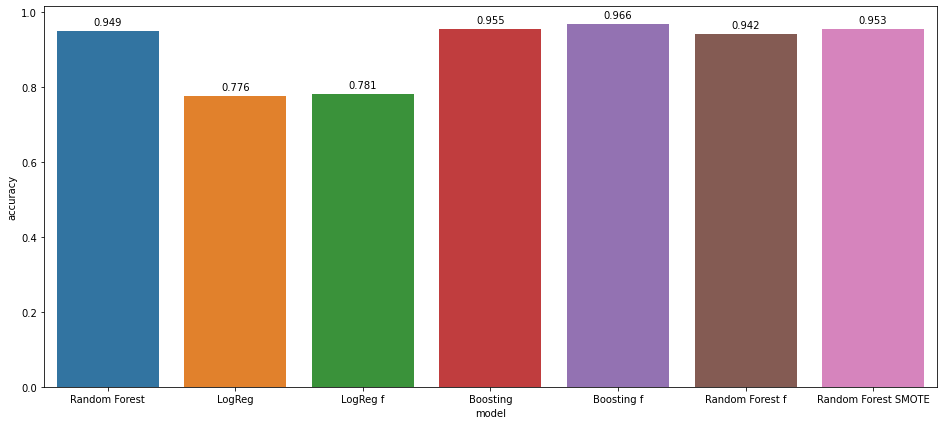

In [ ]:
build_analysis('accuracy')

**PR AUC**

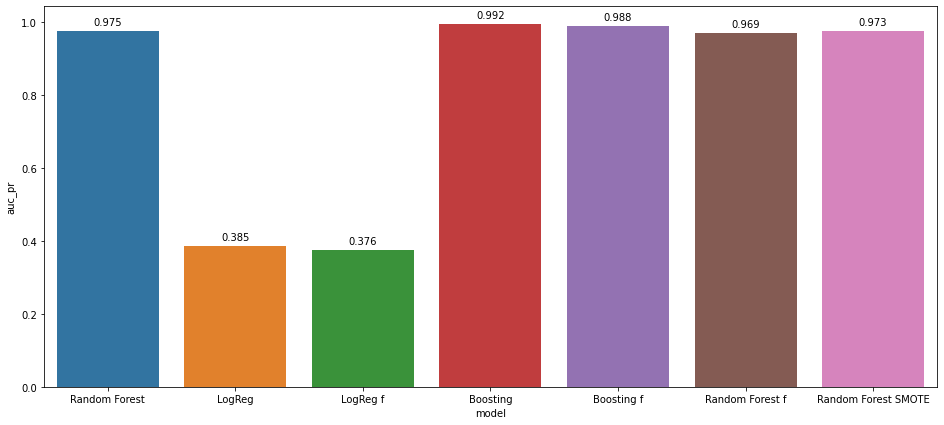

In [ ]:
build_analysis('auc_pr')

**F-мера**

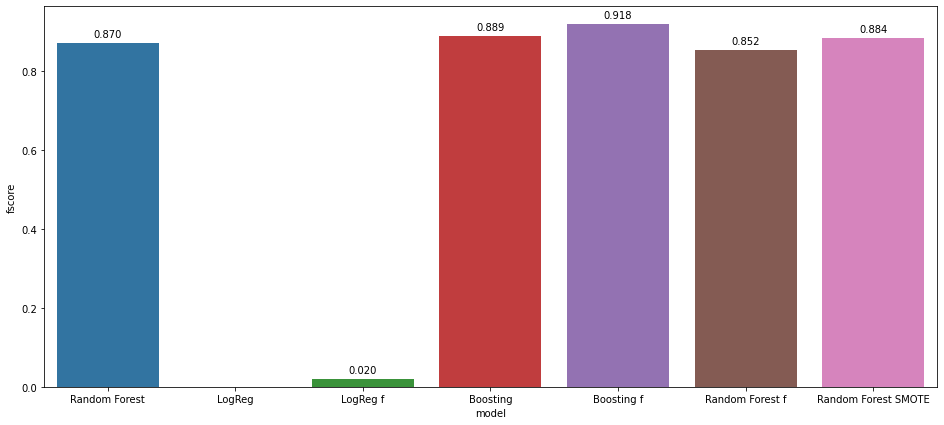

In [ ]:
build_analysis('fscore')

**Финансовые потери**

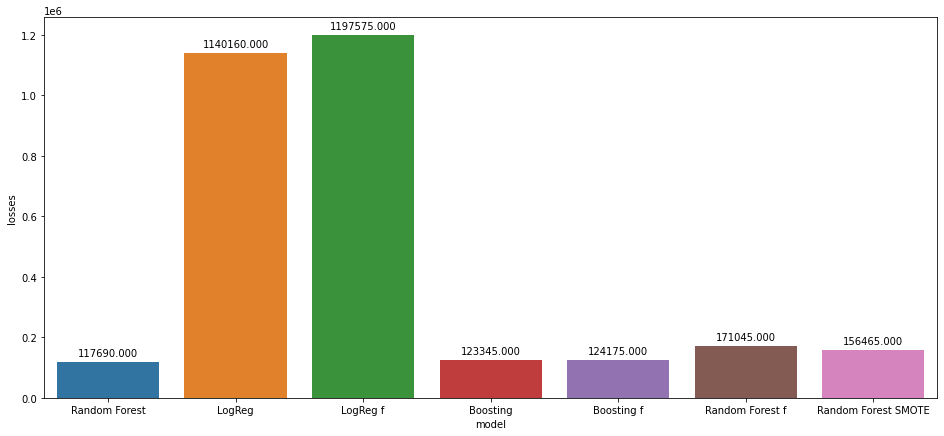

In [ ]:
build_analysis('gains')

**Затраченное время**

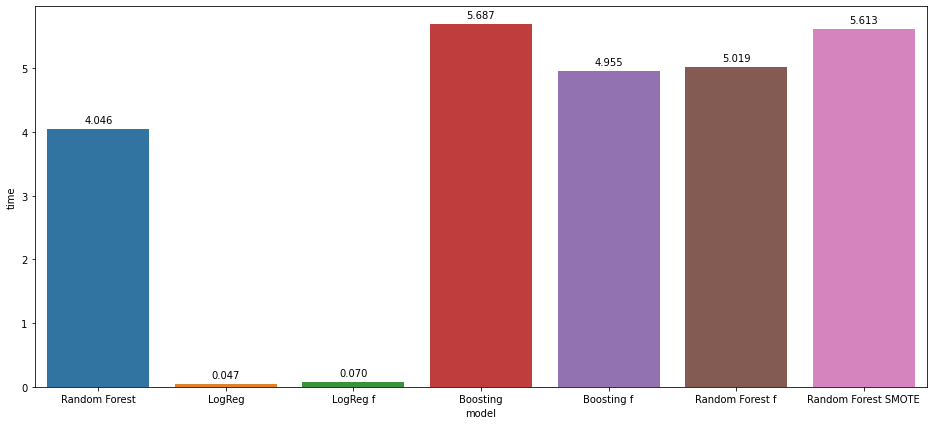

In [ ]:
build_analysis('time')

Забавно, все метрики улучшены, а денег мы теряем больше.

Так как теперь мы активно используем вероятности, предсказанные моделью для нашей калибровки, встает вопрос, насколько эффективно выдача нашей модели оценивает реальную вероятность того, что человек вернет кредит. Построим calibration curve, чтобы оценить качество оценки вероятностей нашей моделью.

# Калибровка модели

In [ ]:
def build_calibration_curve(mod, X, y):
    probs = mod.predict_proba(X)[:, 1]
    vals = []
    for prob in np.arange(0, 1, 0.05):
        vals.append(y[(probs >= prob) & (probs < prob + 0.05)].mean())
    plt.plot(np.arange(0, 1, 0.05) + 0.025, vals, label='Our curve')
    plt.plot(np.arange(0, 1, 0.05) + 0.025, np.arange(0, 1, 0.05) + 0.025, label='Perfect curve')
    return vals

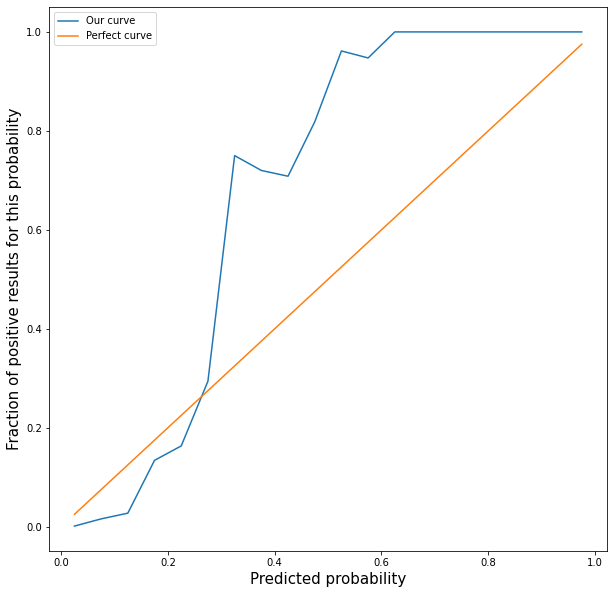

In [ ]:
build_calibration_curve(mod, X_test, y_test)

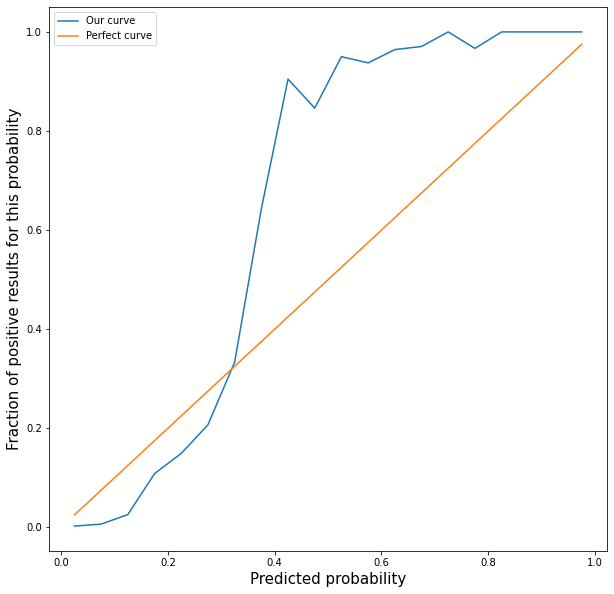

In [ ]:
build_calibration_curve(mod2, X_test, y_test)


Как видно, обе наши модели не очень хорошо передают настоящее распределение вероятностей. Такую "S-образную" форму кривой можно объяснить [$^1$](https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf) высокой вариативностью каждого из деревьев используемых в RandomForest, в результате чего получить среднее предзсказание деревьев ровно в 0 почти невозможно, так как тогда все деревья должны были бы выдать одно и то же нулевое предсказание, что маловероятно.

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
cal_sig_mod = CalibratedClassifierCV(RandomForestClassifier(n_estimators=5000)).fit(X_train, y_train)

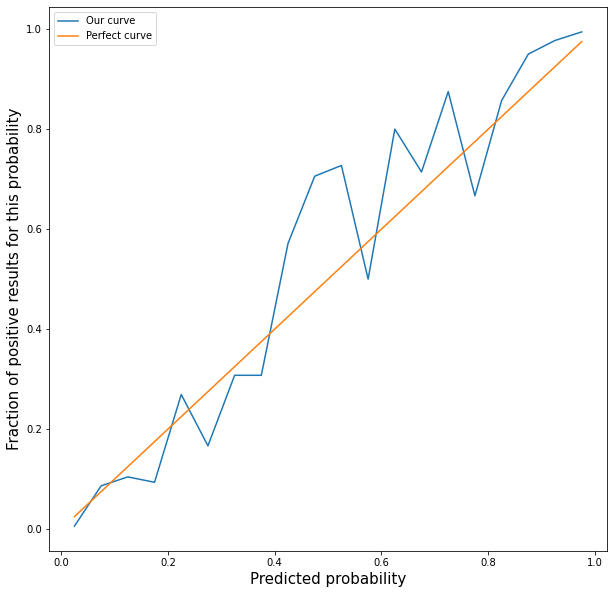

In [ ]:
plt.figure(figsize=(10, 10))
_ = build_calibration_curve(cal_sig_mod, X_test, y_test)
plt.xlabel('Predicted probability', fontdict={'size':15})
plt.ylabel('Fraction of positive results for this probability', fontdict={'size':15})
plt.legend()
plt.show()

In [ ]:
print_metrics(cal_sig_mod, X_test, y_test)

Kappa value: 0.850581748911612
Matthews Correlation Coefficient: 0.8529081456962989
ROC-AUC value: 0.981542860229658
PR-AUC value: 0.9526448681523616
Precision value: 0.934984520123839
Recall value: 0.8296703296703297
Loss: 685050.0


Мы немного увеличили метрики качества классификации, но немного уменьшили нашу целевую метрику - выгоду

In [ ]:
cal_iso_mod = CalibratedClassifierCV(RandomForestClassifier(n_estimators=5000), method='isotonic').fit(X_train, y_train)

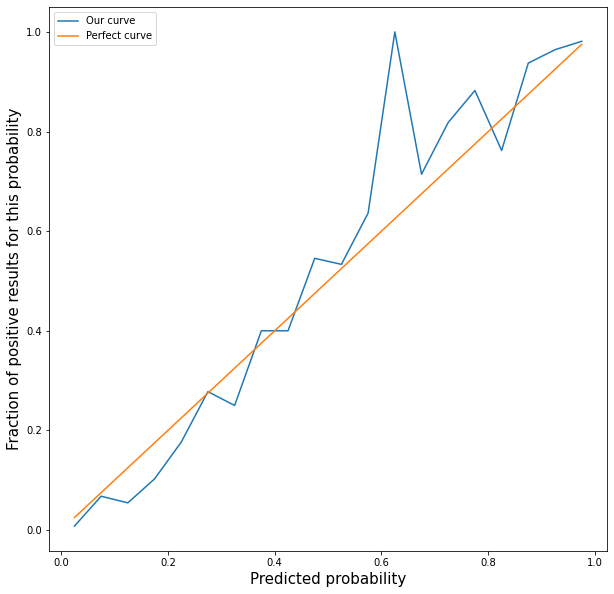

In [ ]:
plt.figure(figsize=(10, 10))
_ = build_calibration_curve(cal_iso_mod, X_test, y_test)
plt.xlabel('Predicted probability', fontdict={'size':15})
plt.ylabel('Fraction of positive results for this probability', fontdict={'size':15})
plt.legend()
plt.show()

In [ ]:
print_metrics(cal_iso_mod, X_test, y_test)

Kappa value: 0.8521595677278214
Matthews Correlation Coefficient: 0.8534616519725069
ROC-AUC value: 0.9807682661439683
PR-AUC value: 0.9515476637678484
Precision value: 0.9219219219219219
Recall value: 0.8434065934065934
Loss: 640400.0


Возможно оверсемплинг выборки вместе с калибровкой вероятностью помогут нам улучшить качество? 

In [ ]:
cal_sig_mod2 = CalibratedClassifierCV(RandomForestClassifier(n_estimators=5000)).fit(X_train_new, y_train_new)

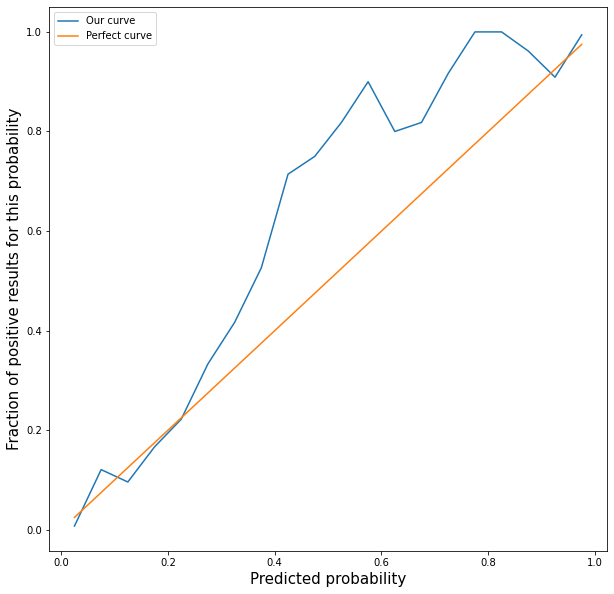

In [ ]:
plt.figure(figsize=(10, 10))
_ = build_calibration_curve(cal_sig_mod2, X_test, y_test)
plt.xlabel('Predicted probability', fontdict={'size':15})
plt.ylabel('Fraction of positive results for this probability', fontdict={'size':15})
plt.legend()
plt.show()

In [ ]:
print_metrics(cal_sig_mod2, X_test, y_test)

Kappa value: 0.8496542219378337
Matthews Correlation Coefficient: 0.8544995777450863
ROC-AUC value: 0.981091415606865
PR-AUC value: 0.9497509146854949
Precision value: 0.9607843137254902
Recall value: 0.8076923076923077
Loss: 690375.0


In [ ]:
cal_iso_mod2 = CalibratedClassifierCV(RandomForestClassifier(n_estimators=5000), method='isotonic').fit(X_train_new, y_train_new)

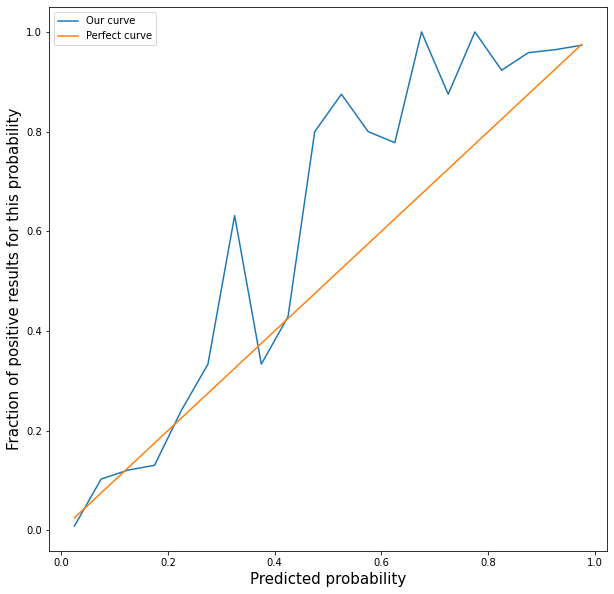

In [ ]:
plt.figure(figsize=(10, 10))
_ = build_calibration_curve(cal_iso_mod2, X_test, y_test)
plt.xlabel('Predicted probability', fontdict={'size':15})
plt.ylabel('Fraction of positive results for this probability', fontdict={'size':15})
plt.legend()
plt.show()

In [ ]:
print_metrics(cal_iso_mod2, X_test, y_test)

Kappa value: 0.8536393700271765
Matthews Correlation Coefficient: 0.8581550644962974
ROC-AUC value: 0.9801865971107544
PR-AUC value: 0.9470570354340664
Precision value: 0.961038961038961
Recall value: 0.8131868131868132
Loss: 696390.0


Улучшение точности предсказания вероятности существующими методами не приводит к улучшению нашей существующей модели, но возможно улучшит результат для наших следующих попыток.

Попробуем усреднить предсказания с и без калибровки, это часто улучшает результат

In [ ]:
def get_prediction2(y_prob, X_test, y_test, x=15):
    threshold = (x / 100) / (1 + x / 100)
    y_pred = y_prob > threshold
    return y_pred * 1.0

In [ ]:
def print_metrics2(mod1, mod2, X_test, y_test):
    y_pred1 = mod1.predict_proba(X_test)[:, 1]
    y_pred2 = mod2.predict_proba(X_test)[:, 1]
    y_predp = ((y_pred1 + y_pred2) / 2)
    y_pred = np.round(y_predp)
    print(f"Kappa value: {kappa(y_pred, y_test)}")
    print(f"Matthews Correlation Coefficient: {matthews(y_pred, y_test)}")
    print(f"ROC-AUC value: {roc_auc_score(y_test, y_predp)}")
    print(f"PR-AUC value: {auc(*reversed((precision_recall_curve(y_test, y_predp))[:2]))}")
    print(f"Precision value: {precision_score(y_test, y_pred)}")
    print(f"Recall value: {recall_score(y_test, y_pred)}")
    y_pred_finance = get_prediction2(y_predp, X_test, y_test)
    print(f"Loss: {get_gain(y_pred_finance, y_test, X_test[:, 0])}")

In [ ]:
print_metrics2(mod, cal_iso_mod2, X_test, y_test)

Kappa value: 0.8389109120055673
Matthews Correlation Coefficient: 0.8454418837139523
ROC-AUC value: 0.9839332016298309
PR-AUC value: 0.9569434407665567
Precision value: 0.9663299663299664
Recall value: 0.7884615384615384
Loss: 610045.0


Наблюдается небольшое улучшение